In [43]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns
from sklearn.impute import SimpleImputer          # 缺失值填补 (Imputation)
from sklearn.preprocessing import StandardScaler  # 标准化 (Standardization)
from sklearn.cluster import KMeans                # K-Means 聚类 (Clustering)
from sklearn.metrics import silhouette_score      # 轮廓系数 (Silhouette)
from sklearn.decomposition import PCA             # 主成分分析 (PCA)
from sklearn.manifold import TSNE                 # t-SNE 降维 (t-SNE)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import kruskal, f_oneway, chi2_contingency
import statsmodels.stats.multitest as smm
import math
import shap

In [44]:
csv_path = "dataset.csv"

colnames = [
    "Age","Gender","TB","DB",
    "Alkphos","sgpt","sgot",
    "TP","ALB","AG_ratio",
    "Selector"
]

df = pd.read_csv(csv_path, header=None, names=colnames)

print("Shape:", df.shape)
display(df.head())                 # see the first few rows
display(df.isna().sum())           # how many missing values per column

#converting gender to binary
df_work = df.copy()
df_work["Gender"] = df_work["Gender"].map({"Male":1, "Female":0})
#df_work["Selector"] = df_work["Selector"].map({1:1, 2:0})
display(df_work.head()) 

display(df_work.describe(include="all"))

Shape: (583, 11)


,Age,Gender,TB,DB,Alkphos,sgpt,sgot,TP,ALB,AG_ratio,Selector
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


Age         0
Gender      0
TB          0
DB          0
Alkphos     0
sgpt        0
sgot        0
TP          0
ALB         0
AG_ratio    4
Selector    0
dtype: int64

,Age,Gender,TB,DB,Alkphos,sgpt,sgot,TP,ALB,AG_ratio,Selector
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1


,Age,Gender,TB,DB,Alkphos,sgpt,sgot,TP,ALB,AG_ratio,Selector
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,579.000000,583.000000
mean,44.746141,0.756432,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,1.286449
std,16.189833,0.429603,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.319592,0.452490
min,4.000000,0.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,1.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,1.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,1.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


In [54]:
# remove target column
numeric_cols = df_work.select_dtypes(include=["number"]).columns.tolist()
if "Selector" in numeric_cols:
    numeric_cols.remove("Selector")

# impute missing values with median
imputer = SimpleImputer(strategy="median")
df_work[numeric_cols] = imputer.fit_transform(df_work[numeric_cols])

# create a copy without the target column
df_work_imputed = df_work.drop(columns=["Selector"], errors="ignore").copy()

display(df_work_imputed.isna().sum())

Age         0
Gender      0
TB          0
DB          0
Alkphos     0
sgpt        0
sgot        0
TP          0
ALB         0
AG_ratio    0
dtype: int64

In [56]:
#normalization datas with mean=0 deviation=1
scaler = StandardScaler()
df_work_scaled = scaler.fit_transform(df_work_imputed)

,K,Inertia,Silhouette
0,2,4782.096977,0.457273
1,3,3950.231086,0.208991
2,4,3365.383649,0.225114
3,5,2993.107182,0.231599
4,6,2706.220488,0.248868
5,7,2510.115986,0.206807
6,8,2350.640101,0.210142


Chosen K = 2


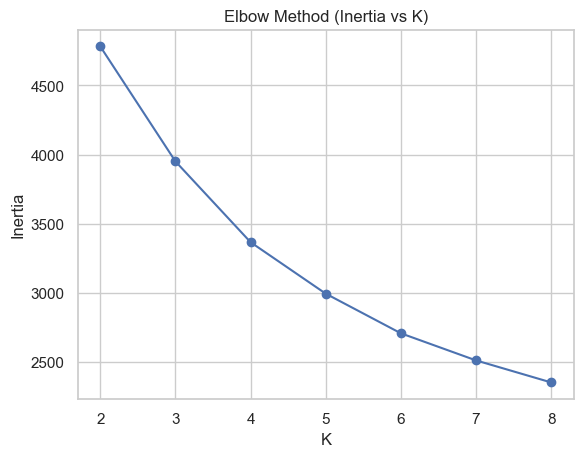

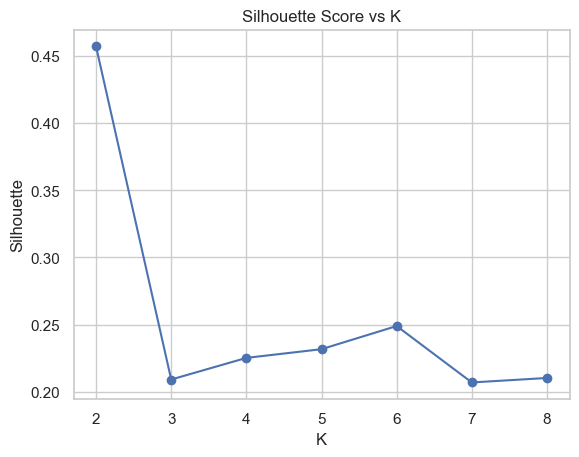

In [57]:
K_values = range(2, 9)
rows = []
for k in K_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10, algorithm="elkan")
    labels = km.fit_predict(df_work_scaled)
    sil = silhouette_score(df_work_scaled, labels)
    rows.append({"K":k, "Inertia":km.inertia_, "Silhouette":sil})

k_table = pd.DataFrame(rows)
display(k_table)

# visualization
plt.figure()
plt.plot(k_table["K"], k_table["Inertia"], marker="o")
plt.xlabel("K"); plt.ylabel("Inertia"); plt.title("Elbow Method (Inertia vs K)")


plt.figure()
plt.plot(k_table["K"], k_table["Silhouette"], marker="o")
plt.xlabel("K"); plt.ylabel("Silhouette"); plt.title("Silhouette Score vs K")


# chose K with highest silhouette score
best_row = k_table.sort_values(["Silhouette","K"], ascending=[False, True]).iloc[0]
best_k = int(best_row["K"])
print("Chosen K =", best_k)

In [58]:
# apply KMeans with the chosen K
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10, algorithm="elkan")
cluster_labels = kmeans.fit_predict(df_work_scaled)

# create a new dataframe with cluster labels that show the number of samples in each cluster
df_clusters = df_work.copy()
df_clusters["Cluster"] = cluster_labels
df_clusters["Cluster"].value_counts().sort_index()


Cluster
0    523
1     60
Name: count, dtype: int64

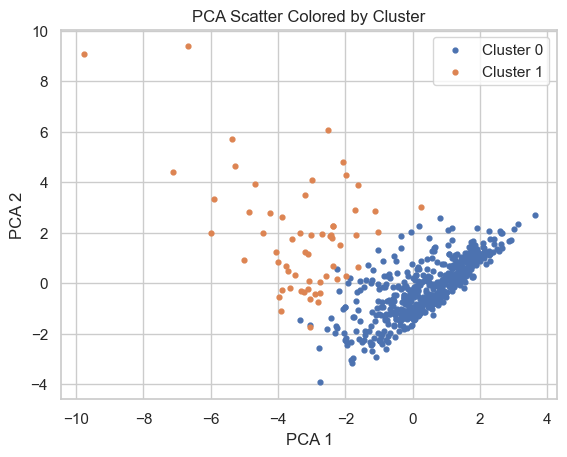

In [59]:
#using PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(df_work_scaled)

plt.figure()
for c in range(best_k):
    idx = (cluster_labels == c)
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=12, label=f"Cluster {c}")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2"); plt.title("PCA Scatter Colored by Cluster")
plt.legend()

In [60]:
# variables summary (mean, std, median)
cont_cols = [c for c in numeric_cols if c != "Gender"]
means = df_clusters.groupby("Cluster")[cont_cols].mean().add_suffix("_mean")
stds  = df_clusters.groupby("Cluster")[cont_cols].std().add_suffix("_std")
meds  = df_clusters.groupby("Cluster")[cont_cols].median().add_suffix("_median")
cont_summary = pd.concat([means, stds, meds], axis=1).sort_index(axis=1)
display(cont_summary)

# sex (binary variable) proportions
bin_counts = df_clusters.groupby("Cluster")["Gender"].sum().rename("Male_count")
bin_totals = df_clusters.groupby("Cluster")["Gender"].count().rename("Total persons")
bin_counts_F = (df_clusters.groupby("Cluster")["Gender"].count() - bin_counts).rename("Female_count")
bin_prop   = (bin_counts / bin_totals).rename("Male_prop")
bin_summary = pd.concat([bin_totals, bin_counts_F, bin_counts, bin_prop], axis=1)
display(bin_summary)

,AG_ratio_mean,AG_ratio_median,AG_ratio_std,ALB_mean,ALB_median,ALB_std,Age_mean,Age_median,Age_std,Alkphos_mean,...,TB_std,TP_mean,TP_median,TP_std,sgot_mean,sgot_median,sgot_std,sgpt_mean,sgpt_median,sgpt_std
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.965220,1.0,0.300762,3.193881,3.2,0.79729,44.728489,45.0,16.398734,272.202677,...,1.704523,6.494837,6.60,1.086133,66.600382,38.0,87.818272,51.340344,32.0,58.043540
1,0.787667,0.7,0.414195,2.688333,2.6,0.62085,44.900000,44.0,14.362970,450.733333,...,11.230949,6.381667,6.45,1.083230,487.433333,203.5,770.468653,336.750000,93.0,474.192467


,Total persons,Female_count,Male_count,Male_prop
Cluster,,,,
0,523,134.0,389.0,0.743786
1,60,8.0,52.0,0.866667


In [61]:
p_kw, p_anova = {}, {}
for col in cont_cols:
    groups = [df_clusters.loc[df_clusters["Cluster"]==c, col].values for c in sorted(df_clusters["Cluster"].unique())]
    p_kw[col] = kruskal(*groups)[1]
    p_anova[col] = f_oneway(*groups)[1]

cols = list(cont_cols)
kw_adj = smm.multipletests([p_kw[c] for c in cols], alpha=0.05, method="fdr_bh")[1]
an_adj = smm.multipletests([p_anova[c] for c in cols], alpha=0.05, method="fdr_bh")[1]

cont_tests = pd.DataFrame({
    "feature": cols,
    "kruskal_p": [p_kw[c] for c in cols],
    "kruskal_p_adj": kw_adj,
    "anova_p": [p_anova[c] for c in cols],
    "anova_p_adj": an_adj,
}).sort_values("kruskal_p_adj")
display(cont_tests)

# 性别（二元）：卡方检验
ct_gender = pd.crosstab(df_clusters["Cluster"], df_clusters["Gender"])
chi2, chi_p, dof, exp = chi2_contingency(ct_gender)
print(f"Chi-square on Gender: chi2={chi2:.3f}, p={chi_p:.6f}, dof={dof}")
display(ct_gender)

,feature,kruskal_p,kruskal_p_adj,anova_p,anova_p_adj
2,DB,2.322056e-35,2.089851e-34,1.568573e-134,1.411715e-133
1,TB,6.880778e-35,3.096350e-34,5.994955e-118,2.697730e-117
5,sgot,9.491140e-21,2.847342e-20,2.058688e-29,4.632049e-29
4,sgpt,8.338487e-17,1.876160e-16,3.444233e-34,1.033270e-33
3,Alkphos,2.072879e-09,3.731183e-09,4.933961e-08,8.881130e-08
8,AG_ratio,2.809478e-07,4.214217e-07,3.880239e-05,4.988879e-05
7,ALB,9.294091e-07,1.194955e-06,2.592473e-06,3.888710e-06
6,TP,3.316789e-01,3.731388e-01,4.447920e-01,5.003910e-01
0,Age,9.854681e-01,9.854681e-01,9.381292e-01,9.381292e-01


Chi-square on Gender: chi2=3.770, p=0.052195, dof=1


Gender,0.0,1.0
Cluster,,
0,134,389
1,8,52


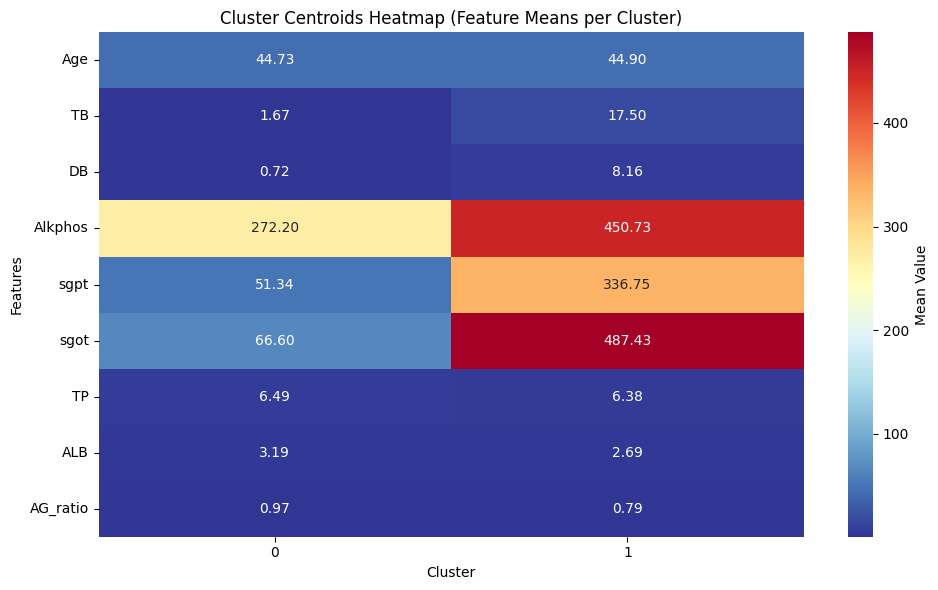

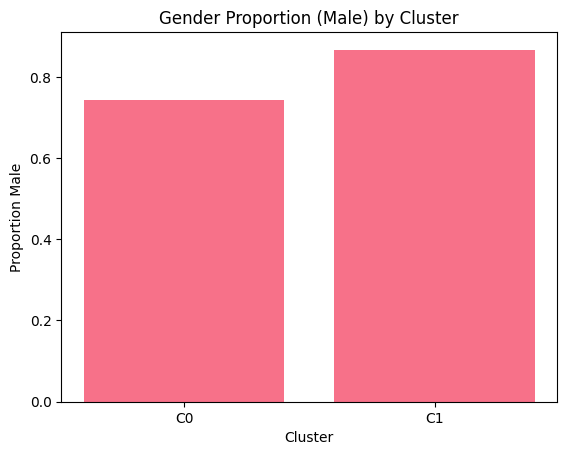

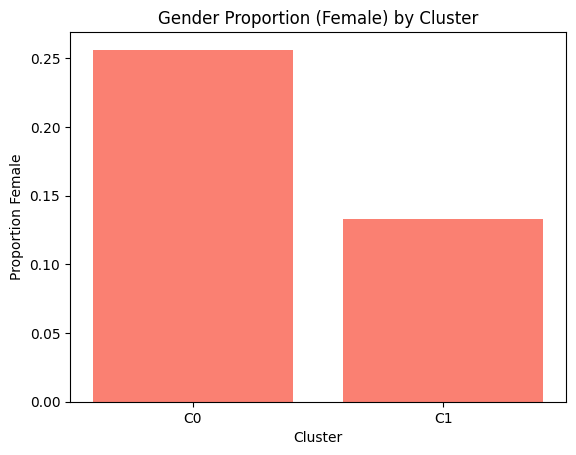

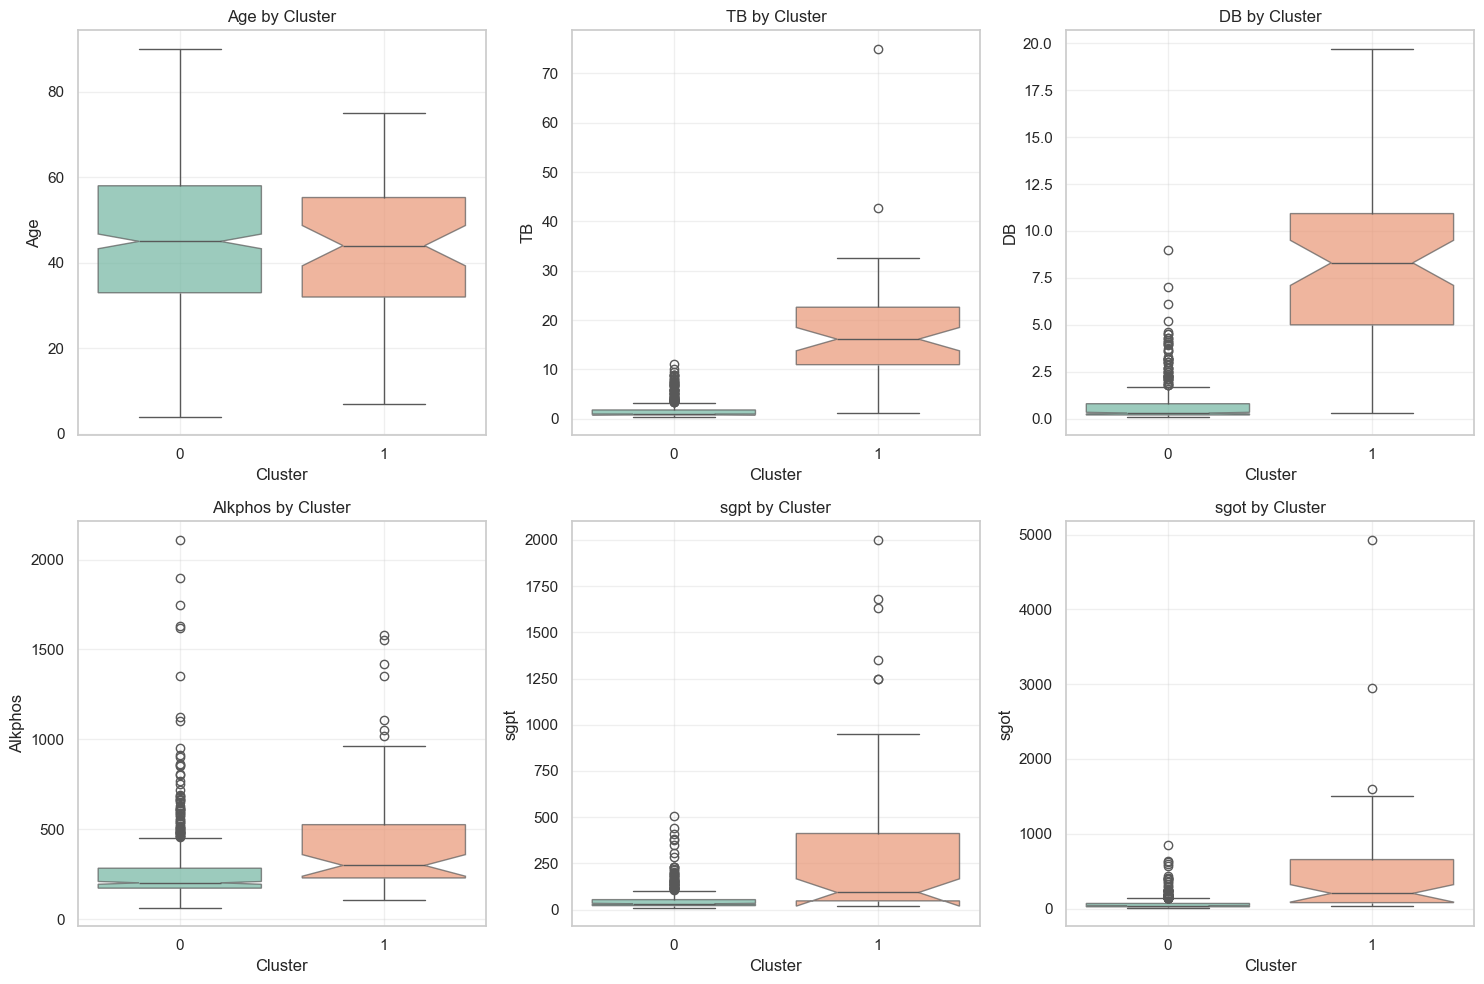

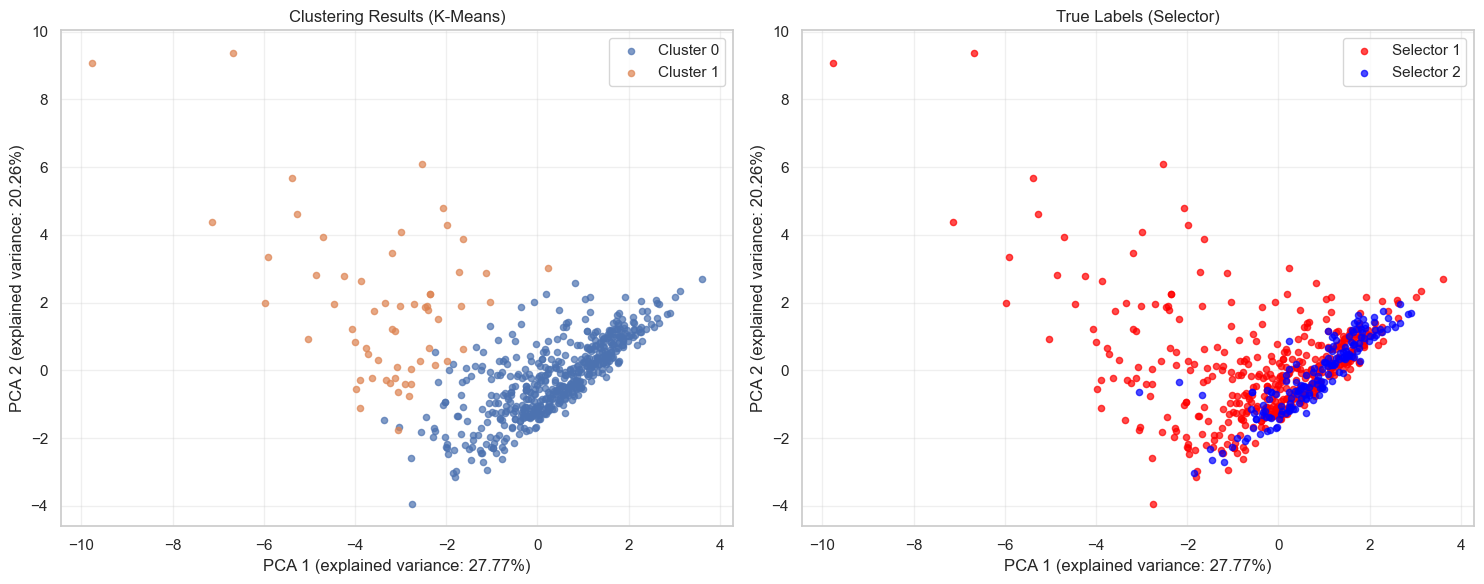

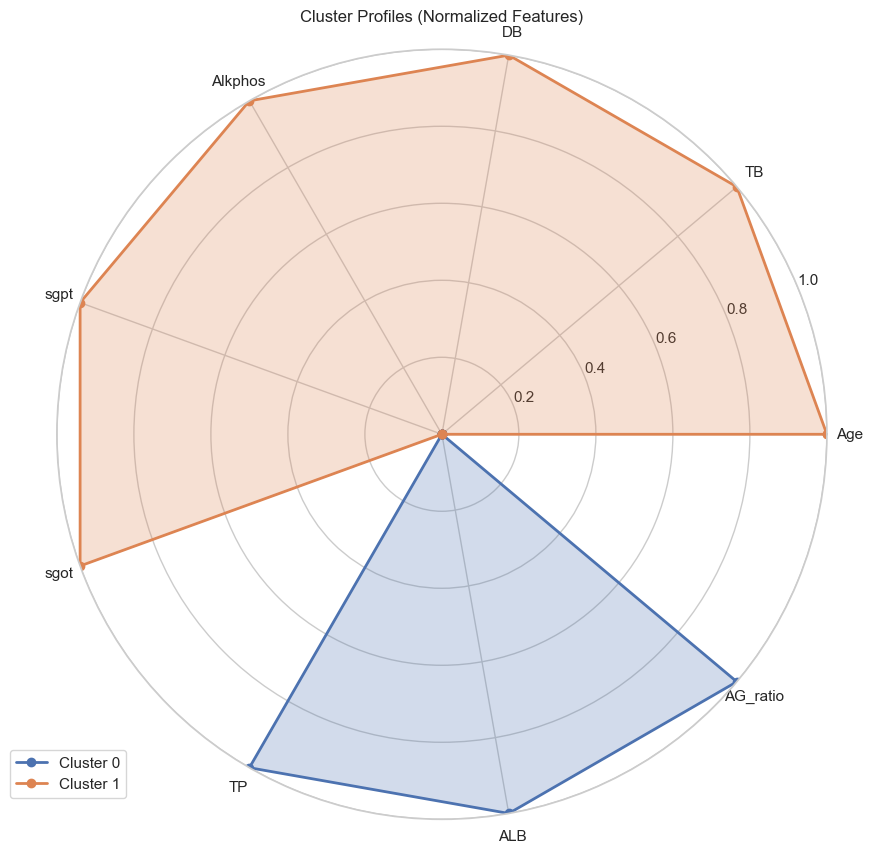

In [62]:

# Set styles
plt.style.use('default')
sns.set_palette("husl")

# 1. HEATMAP for Cluster Centroids
plt.figure(figsize=(10, 6))
cluster_means = df_clusters.groupby("Cluster")[cont_cols].mean()
ax = sns.heatmap(cluster_means.T, annot=True, cmap='RdYlBu_r', fmt='.2f', 
                 cbar_kws={'label': 'Mean Value'})
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
plt.title('Cluster Centroids Heatmap (Feature Means per Cluster)')
plt.xlabel('Cluster')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# 2. BAR Chart porpotion of Gender Distribution by Cluster
gender_prop = df_clusters.groupby("Cluster")["Gender"].mean()
plt.figure()
plt.bar([f"C{c}" for c in gender_prop.index], gender_prop.values)
plt.xlabel("Cluster"); plt.ylabel("Proportion Male"); plt.title("Gender Proportion (Male) by Cluster")
plt.show()

female_prop = 1 - gender_prop                                   # female
plt.figure()
plt.bar([f"C{c}" for c in gender_prop.index], female_prop.values, color="salmon")
plt.xlabel("Cluster")
plt.ylabel("Proportion Female")
plt.title("Gender Proportion (Female) by Cluster")
plt.show()

# 3. BOX Plot for Key Features by Cluster
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

key_features = ['Age', 'TB', 'DB', 'Alkphos', 'sgpt', 'sgot']

for i, feature in enumerate(key_features):
    if feature in df_clusters.columns:
        sns.boxplot(
            data=df_clusters,
            x='Cluster', y=feature,
            hue='Cluster',        
            palette='Set2',       
            notch=True,           
            legend=False,         
            ax=axes[i],
            boxprops=dict(alpha=0.7)
        )
        axes[i].set_title(f'{feature} by Cluster', fontsize=12)
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. PCA Dimensionality Reduction Scatter Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# colored by cluster labels
for c in range(best_k):
    idx = (cluster_labels == c)
    ax1.scatter(X_pca[idx,0], X_pca[idx,1], s=20, alpha=0.7, label=f"Cluster {c}")
ax1.set_xlabel(f"PCA 1 (explained variance: {pca.explained_variance_ratio_[0]:.2%})")
ax1.set_ylabel(f"PCA 2 (explained variance: {pca.explained_variance_ratio_[1]:.2%})")
ax1.set_title("Clustering Results (K-Means)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# true labels if available
if 'Selector' in df_clusters.columns:
    unique_selectors = df_clusters['Selector'].unique()
    colors = ['red', 'blue', 'green', 'orange']
    for i, selector in enumerate(unique_selectors):
        idx = (df_clusters['Selector'] == selector)
        ax2.scatter(X_pca[idx,0], X_pca[idx,1], s=20, alpha=0.7, 
                   c=colors[i % len(colors)], label=f"Selector {selector}")
    ax2.set_xlabel(f"PCA 1 (explained variance: {pca.explained_variance_ratio_[0]:.2%})")
    ax2.set_ylabel(f"PCA 2 (explained variance: {pca.explained_variance_ratio_[1]:.2%})")
    ax2.set_title("True Labels (Selector)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No Selector column\nfor comparison', 
             transform=ax2.transAxes, ha='center', va='center', fontsize=12)
    ax2.set_title("True Labels (Not Available)")

plt.tight_layout()
plt.show()



# standardize cluster means to 0-1 range
cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

# radar chart
angles = [n / len(cont_cols) * 2 * pi for n in range(len(cont_cols))]
angles += angles[:1]  

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

for cluster in range(best_k):
    values = cluster_means_norm.iloc[cluster].tolist()
    values += values[:1]  
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(cont_cols)
ax.set_ylim(0, 1)
ax.set_title('Cluster Profiles (Normalized Features)', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()


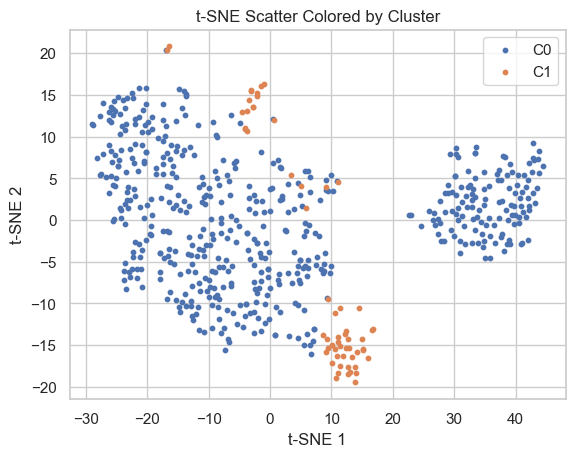

In [63]:
# t-SNE 2D
tsne = TSNE(n_components=2, random_state=42, init="pca", learning_rate="auto", perplexity=35)
X_tsne = tsne.fit_transform(df_work_scaled)

plt.figure()
for c in sorted(df_clusters["Cluster"].unique()):
    idx = (df_clusters["Cluster"] == c)
    plt.scatter(X_tsne[idx,0], X_tsne[idx,1], s=10, label=f"C{c}")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2"); plt.title("t-SNE Scatter Colored by Cluster")
plt.legend()
plt.show()

Features used: ['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'sgpt', 'sgot', 'TP', 'ALB', 'AG_ratio']
X_tree shape: (583, 10)
Random Forest accuracy: 0.993


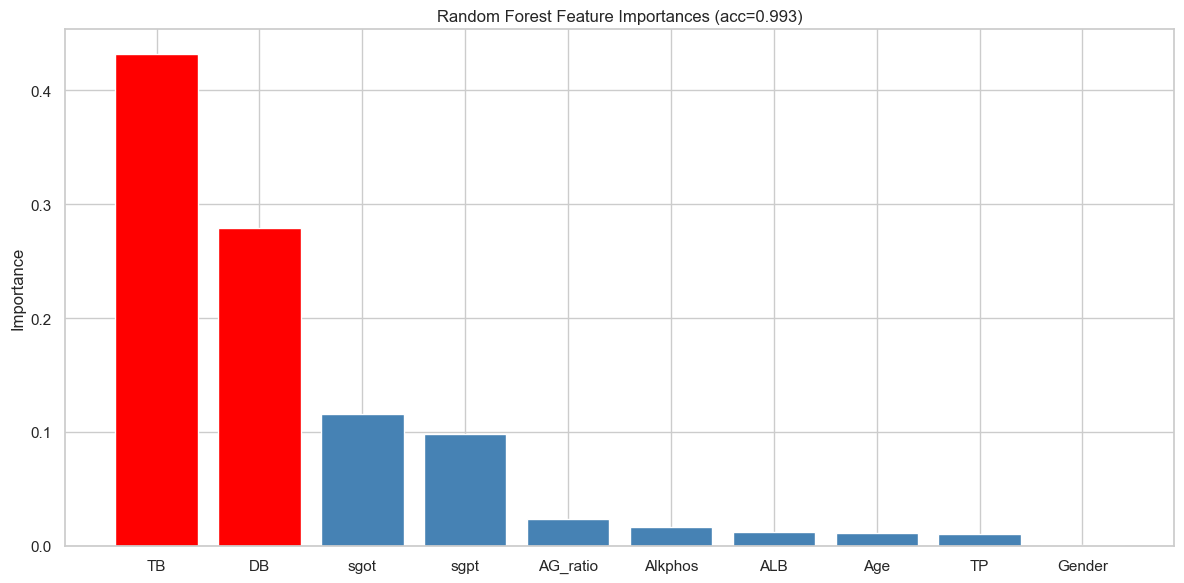

,feature,importance
0,TB,0.432051
1,DB,0.279121
2,sgot,0.115962
3,sgpt,0.097863
4,AG_ratio,0.023675
5,Alkphos,0.016817
6,ALB,0.012247
7,Age,0.010694
8,TP,0.010566
9,Gender,0.001004


In [69]:
# Random Forest — feature importance (robust version)
# 1. Data preparation
X_tree = df_work_imputed[numeric_cols].copy()   # use all numeric features
y = df_clusters["Cluster"].values

print(f"Features used: {numeric_cols}")
print(f"X_tree shape: {X_tree.shape}")

# 2. Train / test split (25% test)
X_tr, X_te, y_tr, y_te = train_test_split(
    X_tree, y, test_size=0.25, random_state=42, stratify=y
)

# 3. Train Random Forest
rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
rf.fit(X_tr, y_tr)
acc = rf.score(X_te, y_te)
print(f"Random Forest accuracy: {acc:.3f}")

# 4. Extract and sort feature importances (align safely with names)
importances = rf.feature_importances_
feature_names = X_tree.columns.tolist()

# Guard against NaNs
if np.isnan(importances).any():
    print("Warning: NaNs found in feature importances; replacing with 0.0")
    importances = np.nan_to_num(importances, nan=0.0)

imp_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)
feat_order = imp_series.index.tolist()
imp_vals = imp_series.values
n = len(feat_order)

# 5. Plot feature importances (highlight TB and DB if present)
plt.figure(figsize=(12, 6))

highlight_candidates = ['TB', 'DB']
highlight_features = [f for f in highlight_candidates if f in feat_order]
colors = ['red' if f in highlight_features else 'steelblue' for f in feat_order]

x = np.arange(n)
plt.bar(x, imp_vals, color=colors)
plt.xticks(x, feat_order, rotation=0, ha="center")
plt.title(f"Random Forest Feature Importances (acc={acc:.3f})")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# 6. Display feature importance table
fi_df = pd.DataFrame({"feature": feat_order, "importance": imp_vals})
display(fi_df)

In [71]:
# SHAP analysis - explain clustering feature importance
# using the same data as Random Forest
X_tree = df_work_imputed[numeric_cols].copy()  # use all numeric features
y = df_clusters["Cluster"].values

print(f"SHAP analysis features: {list(X_tree.columns)}")
print(f"Number of features: {len(X_tree.columns)}")

# Train/test split (same as before with Random Forest)
X_tr, X_te, y_tr, y_te = train_test_split(X_tree, y, test_size=0.25, random_state=42, stratify=y)

# Use a small portion of the training set as background data (faster and more stable)
background = shap.utils.sample(X_tr, min(200, len(X_tr)), random_state=42)

explainer = shap.TreeExplainer(model=rf, data=background, feature_perturbation="interventional")
# calculate SHAP for the test set (can also do for full X_tree but slower)
shap_values = explainer.shap_values(X_te)   # this is a list, length = number of classes (i.e., clusters)
base_values = explainer.expected_value      # corresponding expected output for each class

print(f"SHAP values type: {type(shap_values)}, length: {len(shap_values)}")
print(f"Shape of each class SHAP values: {shap_values[0].shape}")
print(f"Feature names from X_tree: {list(X_tree.columns)}")

SHAP analysis features: ['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'sgpt', 'sgot', 'TP', 'ALB', 'AG_ratio']
Number of features: 10
SHAP values type: <class 'numpy.ndarray'>, length: 146
Shape of each class SHAP values: (10, 2)
Feature names from X_tree: ['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'sgpt', 'sgot', 'TP', 'ALB', 'AG_ratio']


🔍 Debug info:
- SHAP values type: <class 'numpy.ndarray'>
- SHAP values shape: (146, 10, 2)
- best_k (actual clusters): 4
- Unique cluster labels: [np.int32(0), np.int32(1)]
- Test set size: 146
- Test set cluster distribution: [131  15]
- SHAP array shape: (146, 10, 2)
- Format: 3D array (multi-class)
- Samples: 146, Features: 10, Classes: 2
- Feature names: ['Age', 'Gender', 'TB', 'DB', 'Alkphos', 'sgpt', 'sgot', 'TP', 'ALB', 'AG_ratio']

🔍 SHAP values verification:
- Class 0 SHAP shape: (146, 10)
- Class 0 SHAP range: [-0.5983, 0.0510]
- Class 0 SHAP mean per feature: [0.0013 0.0002 0.0825]
- Class 1 SHAP shape: (146, 10)
- Class 1 SHAP range: [-0.0510, 0.5983]
- Class 1 SHAP mean per feature: [0.0013 0.0002 0.0825]
- Processing 2 clusters out of 2 SHAP classes
- Cluster 0: 131 samples, SHAP mean: [0.0011 0.0001 0.0467]
- Cluster 1: 15 samples, SHAP mean: [0.0036 0.0008 0.3955]

⚠️  max diff (Cluster 0 vs 1): 0.348861

📊 SHAP pivot table shape: (10, 2)
top 3 features:
Cluster       

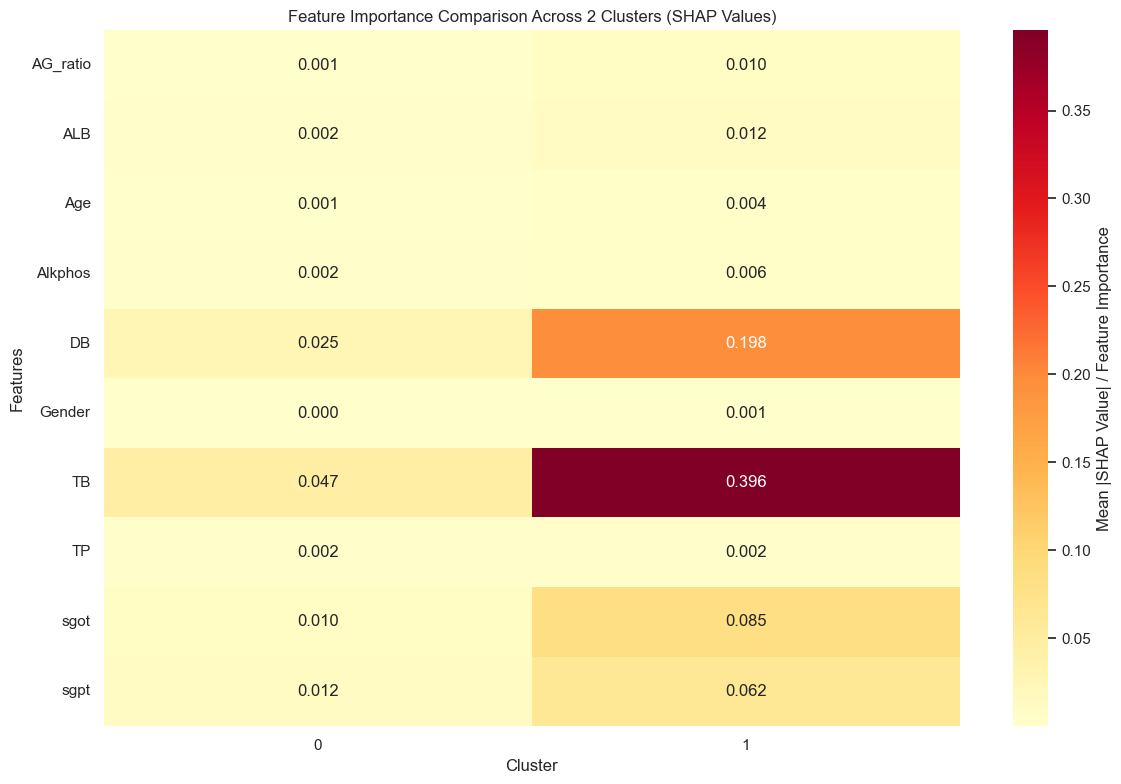

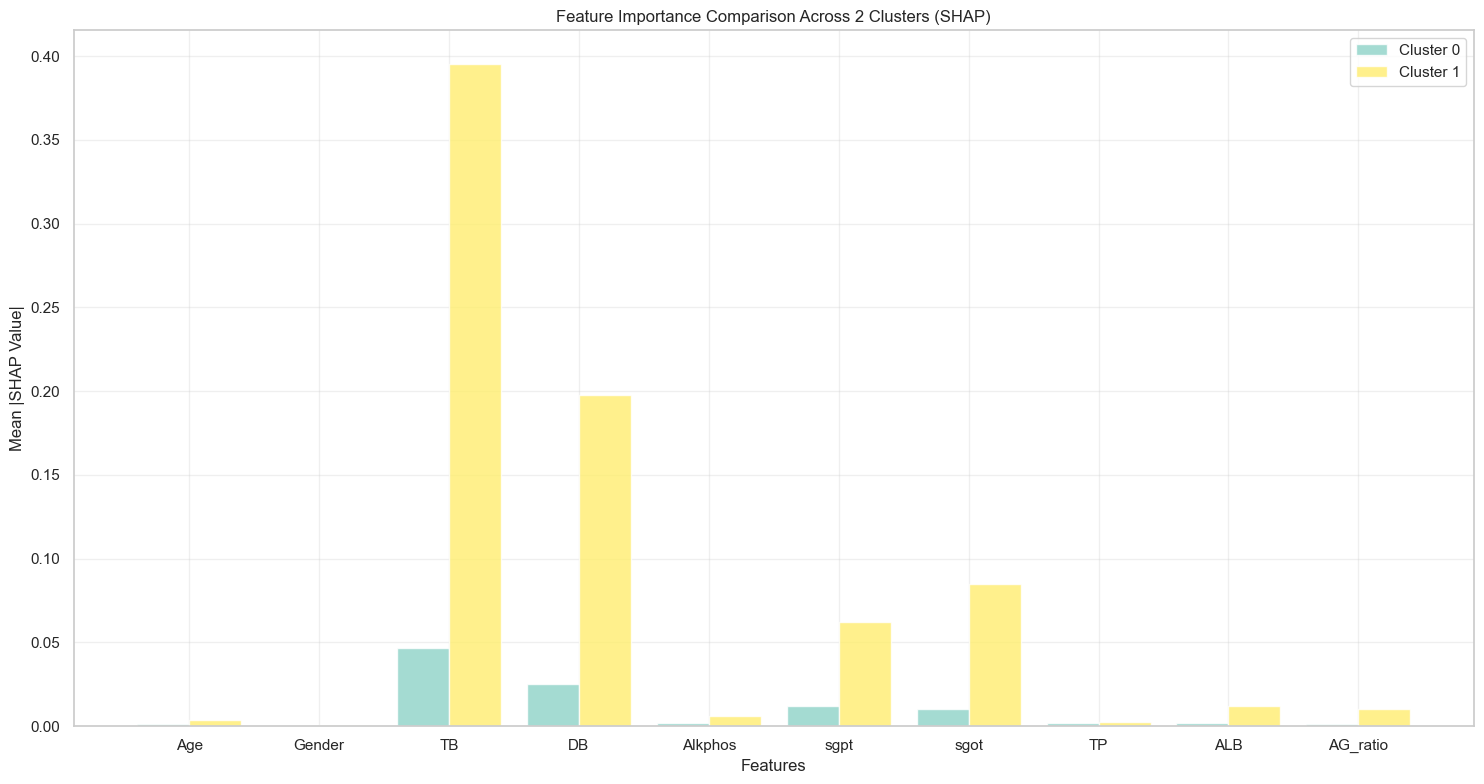


📊 Feature Importance by Cluster (Top 2 clusters):


Cluster,0,1
Feature,,
AG_ratio,0.0012,0.0099
ALB,0.0019,0.0121
Age,0.0011,0.0036
Alkphos,0.0017,0.0060
DB,0.0252,0.1978
Gender,0.0001,0.0008
TB,0.0467,0.3955
TP,0.0019,0.0024
sgot,0.0101,0.0845



🔝 Top 5 Features for Each Cluster:

Cluster 0:
  1. TB: 0.0467
  2. DB: 0.0252
  3. sgpt: 0.0117
  4. sgot: 0.0101
  5. ALB: 0.0019

Cluster 1:
  1. TB: 0.3955
  2. DB: 0.1978
  3. sgot: 0.0845
  4. sgpt: 0.0624
  5. ALB: 0.0121

✅ SHAP analysis completed!


In [72]:
# visualize SHAP values for all clusters - revised version
try:
    # verify the actual structure of SHAP values
    print(f"🔍 Debug info:")
    print(f"- SHAP values type: {type(shap_values)}")
    print(f"- SHAP values shape: {np.array(shap_values).shape if hasattr(shap_values, '__len__') else 'No shape'}")
    print(f"- best_k (actual clusters): {4}")
    print(f"- Unique cluster labels: {sorted(np.unique(y))}")
    print(f"- Test set size: {len(y_te)}")
    print(f"- Test set cluster distribution: {np.bincount(y_te)}")
    
    # determine the structure of shap_values
    if isinstance(shap_values, np.ndarray):
        shap_shape = shap_values.shape
        print(f"- SHAP array shape: {shap_shape}")
        
        if len(shap_shape) == 3:
            # 3D array: (n_samples, n_features, n_classes)
            print("- Format: 3D array (multi-class)")
            n_samples, n_features, n_classes = shap_shape
            
            feature_names = list(X_tree.columns)[:n_features]
            print(f"- Samples: {n_samples}, Features: {n_features}, Classes: {n_classes}")
            print(f"- Feature names: {feature_names}")
            
            # verify SHAP values per class
            print(f"\n🔍 SHAP values verification:")
            for class_id in range(min(3, n_classes)):  # check first 3 classes
                class_shap = shap_values[:, :, class_id]
                print(f"- Class {class_id} SHAP shape: {class_shap.shape}")
                print(f"- Class {class_id} SHAP range: [{class_shap.min():.4f}, {class_shap.max():.4f}]")
                print(f"- Class {class_id} SHAP mean per feature: {np.mean(np.abs(class_shap), axis=0)[:3].round(4)}")
            
            # use only the actual number of clusters
            actual_clusters = min(n_classes, 4)
            print(f"- Processing {actual_clusters} clusters out of {n_classes} SHAP classes")
            
            # calculate mean absolute SHAP values per cluster
            cluster_shap_importance = {}
            all_shap_data = []
            
            for cluster_id in range(actual_clusters):
                # take SHAP values for this cluster
                sv = shap_values[:, :, cluster_id]
                
                # be sure to only consider samples belonging to this cluster
                cluster_mask = (y_te == cluster_id)
                if np.sum(cluster_mask) > 0:
                    # calculate SHAP values
                    sv_cluster = sv[cluster_mask, :]
                    mean_abs = np.mean(np.abs(sv_cluster), axis=0)
                    print(f"- Cluster {cluster_id}: {np.sum(cluster_mask)} samples, SHAP mean: {mean_abs[:3].round(4)}")
                else:
                    # use overall mean if no samples in this cluster
                    mean_abs = np.mean(np.abs(sv), axis=0)
                    print(f"- Cluster {cluster_id}: No samples in test set, using overall mean")
                
                cluster_shap_importance[cluster_id] = mean_abs
                
                # prepare data for pivot table
                for i, feature in enumerate(feature_names):
                    all_shap_data.append({
                        'Cluster': cluster_id,
                        'Feature': feature,
                        'Mean_SHAP': mean_abs[i]
                    })
            
            # verify if clusters have distinct SHAP importances - revised
            importance_arrays = [cluster_shap_importance[i] for i in range(actual_clusters)]
            if len(importance_arrays) > 1:
                diff_matrix = np.abs(np.array(importance_arrays[0]) - np.array(importance_arrays[1]))
                max_diff = np.max(diff_matrix)
                print(f"\n⚠️  max diff (Cluster 0 vs 1): {max_diff:.6f}")
                if max_diff < 1e-10:
                    print("❌ warning: All clusters have nearly identical SHAP importances!")
                    
                    # use statistical analysis as alternative
                    print("\n🔧 use statistical analysis as alternative")
                    
                    # for each cluster, calculate mean and std deviation of features
                    cluster_feature_stats = {}
                    overall_mean = X_tree.mean()
                    overall_std = X_tree.std()
                    
                    for cluster_id in range(actual_clusters):
                        cluster_data = X_tree[y == cluster_id]
                        if len(cluster_data) > 0:
                            # calculate (z-score difference)
                            cluster_mean = cluster_data.mean()
                            z_diff = np.abs((cluster_mean - overall_mean) / overall_std)
                            cluster_feature_stats[cluster_id] = z_diff
                            print(f"- Cluster {cluster_id} number of sample: {len(cluster_data)}")
                            print(f"- Cluster {cluster_id} feature diff (3 first): {z_diff[:3].round(4)}")

                    # use feature statistics instead of SHAP
                    cluster_shap_importance = cluster_feature_stats
                    all_shap_data = []
                    for cluster_id in range(actual_clusters):
                        for i, feature in enumerate(feature_names):
                            all_shap_data.append({
                                'Cluster': cluster_id,
                                'Feature': feature,
                                'Mean_SHAP': cluster_shap_importance[cluster_id][i]
                            })
            
            # create pivot table for heatmap
            shap_comparison_df = pd.DataFrame(all_shap_data)
            shap_pivot = shap_comparison_df.pivot(index='Feature', columns='Cluster', values='Mean_SHAP')
            
            print(f"\n📊 SHAP pivot table shape: {shap_pivot.shape}")
            print("top 3 features:")
            print(shap_pivot.head(3).round(4))
            
            # 1. heatmap: feature importance per cluster
            plt.figure(figsize=(12, 8))
            ax=sns.heatmap(shap_pivot, annot=True, cmap='YlOrRd', fmt='.3f', 
                        cbar_kws={'label': 'Mean |SHAP Value| / Feature Importance'})
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
            title_suffix = "(SHAP Values)" if max_diff >= 1e-10 else "(Statistical Differences)"
            plt.title(f'Feature Importance Comparison Across {actual_clusters} Clusters {title_suffix}')
            plt.xlabel('Cluster')
            plt.ylabel('Features')
            plt.tight_layout()
            plt.show()
            
            # 2. bar chart: feature importance per cluster
            fig, ax = plt.subplots(figsize=(15, 8))
            x = np.arange(len(feature_names))
            width = 0.8 / actual_clusters
            colors = plt.cm.Set3(np.linspace(0, 1, actual_clusters))
            
            for cluster_id in range(actual_clusters):
                values = [cluster_shap_importance[cluster_id][i] for i in range(len(feature_names))]
                offset = (cluster_id - (actual_clusters-1)/2) * width
                ax.bar(x + offset, values, width, 
                       label=f'Cluster {cluster_id}', color=colors[cluster_id], alpha=0.8)
            
            ax.set_xlabel('Features')
            ylabel = 'Mean |SHAP Value|' if max_diff >= 1e-10 else 'Statistical Difference (Z-score)'
            ax.set_ylabel(ylabel)
            title_suffix = "(SHAP)" if max_diff >= 1e-10 else "(Statistical Analysis)"
            ax.set_title(f'Feature Importance Comparison Across {actual_clusters} Clusters {title_suffix}')
            ax.set_xticks(x)
            ax.set_xticklabels(feature_names, rotation=0, ha='center')
            ax.legend()
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # 3. detailed table of feature importances
            print(f"\n📊 Feature Importance by Cluster (Top {actual_clusters} clusters):")
            display(shap_pivot.round(4))
            
            # 4. top 5 features per cluster
            print(f"\n🔝 Top 5 Features for Each Cluster:")
            for cluster_id in range(actual_clusters):
                importance_scores = cluster_shap_importance[cluster_id]
                order = np.argsort(importance_scores)[::-1]
                top5_features = [feature_names[i] for i in order[:5]]
                top5_scores = [importance_scores[i] for i in order[:5]]
                
                print(f"\nCluster {cluster_id}:")
                for i, (feat, score) in enumerate(zip(top5_features, top5_scores), 1):
                    print(f"  {i}. {feat}: {score:.4f}")
        
        elif len(shap_shape) == 2:
            # 2d classes: (n_samples, n_features)
            print("- Format: 2D array (regression/binary)")
            n_samples, n_features = shap_shape
            
            feature_names = list(X_tree.columns)[:n_features]
            print(f"- Using {n_features} features: {feature_names}")
            
            # calculate mean absolute SHAP values per feature
            mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
            
            # create bar chart for overall feature importance
            plt.figure(figsize=(12, 6))
            order = np.argsort(mean_abs_shap)[::-1]
            feat_sorted = [feature_names[i] for i in order]
            vals_sorted = mean_abs_shap[order]
            
            plt.bar(range(len(feat_sorted)), vals_sorted)
            plt.xticks(range(len(feat_sorted)), feat_sorted, rotation=45, ha='right')
            plt.title('SHAP Feature Importance (Overall)')
            plt.ylabel('Mean |SHAP Value|')
            plt.tight_layout()
            plt.show()
            
            # show table of feature importances
            shap_df = pd.DataFrame({
                'Feature': feat_sorted,
                'Mean_SHAP': vals_sorted
            })
            display(shap_df.round(4))
        
        else:
            print(f"- Unexpected SHAP array dimensions: {len(shap_shape)}D")
            
    elif isinstance(shap_values, list) and len(shap_values) > 0:
        # multi-class SHAP values as list of arrays
        print("- Format: List of arrays (multi-class)")
        n_classes = len(shap_values)
        
        # validate SHAP array shape
        first_shape = shap_values[0].shape
        print(f"- Each class SHAP shape: {first_shape}")
        print(f"- Number of classes in SHAP: {n_classes}")
        
        if len(first_shape) == 2:
            n_samples, n_features = first_shape
            feature_names = list(X_tree.columns)[:n_features]
            print(f"- Using {n_features} features: {feature_names}")
            
            # validate SHAP values per class
            print(f"\n🔍 verify SHAP values:")
            for i in range(min(3, n_classes)):
                sv = shap_values[i]
                print(f"- Class {i}: shape={sv.shape}, range=[{sv.min():.4f}, {sv.max():.4f}]")
                print(f"- Class {i} mean abs per feature: {np.mean(np.abs(sv), axis=0)[:3].round(4)}")

            # use (best_k)
            actual_clusters = min(n_classes, 4)
            print(f"- Processing {actual_clusters} clusters out of {n_classes} SHAP arrays")
            
            # calculate feature importance per cluster
            cluster_shap_importance = {}
            all_shap_data = []
            
            for cluster_id in range(actual_clusters):
                sv = shap_values[cluster_id]  # (n_test_samples, n_features)
                mean_abs = np.mean(np.abs(sv), axis=0)
                cluster_shap_importance[cluster_id] = mean_abs
                
                print(f"- Cluster {cluster_id} SHAP mean: {mean_abs[:3].round(4)}")
                
                # data for heatmap
                for i, feature in enumerate(feature_names):
                    all_shap_data.append({
                        'Cluster': cluster_id,
                        'Feature': feature,
                        'Mean_SHAP': mean_abs[i]
                    })
            
            # validate differences between clusters
            if len(cluster_shap_importance) > 1:
                diff = np.abs(cluster_shap_importance[0] - cluster_shap_importance[1])
                max_diff = np.max(diff)
                print(f"\n⚠️  max diff (Cluster 0 vs 1): {max_diff:.6f}")

            # create SHAP importance DataFrame
            shap_comparison_df = pd.DataFrame(all_shap_data)
            shap_pivot = shap_comparison_df.pivot(index='Feature', columns='Cluster', values='Mean_SHAP')
            
            print(f"\nSHAP pivot table shape: {shap_pivot.shape}")
            
            # 1. heatmap for all clusters feature importance comparison
            plt.figure(figsize=(12, 8))
            ax=sns.heatmap(shap_pivot, annot=True, cmap='YlOrRd', fmt='.3f', 
                        cbar_kws={'label': 'Mean |SHAP Value|'})
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
            plt.title(f'SHAP Feature Importance Comparison Across {actual_clusters} Clusters')
            plt.xlabel('Cluster')
            plt.ylabel('Features')
            plt.tight_layout()
            plt.show()
            
            # 2. bar chart
            fig, ax = plt.subplots(figsize=(15, 8))
            x = np.arange(len(feature_names))
            width = 0.8 / actual_clusters
            colors = plt.cm.Set3(np.linspace(0, 1, actual_clusters))
            
            for cluster_id in range(actual_clusters):
                values = [cluster_shap_importance[cluster_id][i] for i in range(len(feature_names))]
                offset = (cluster_id - (actual_clusters-1)/2) * width
                ax.bar(x + offset, values, width, 
                       label=f'Cluster {cluster_id}', color=colors[cluster_id], alpha=0.8)
            
            ax.set_xlabel('Features')
            ax.set_ylabel('Mean |SHAP Value|')
            ax.set_title(f'Feature Importance Comparison Across {actual_clusters} Clusters (SHAP)')
            ax.set_xticks(x)
            ax.set_xticklabels(feature_names, rotation=0, ha='center')
            ax.legend()
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

            # 3. details table
            print(f"\n📊 SHAP Feature Importance by Cluster (Top {actual_clusters} clusters):")
            display(shap_pivot.round(4))
            
            # 4. top 5 features for each cluster
            print(f"\n🔝 Top 5 Features for Each Cluster:")
            for cluster_id in range(actual_clusters):
                importance_scores = cluster_shap_importance[cluster_id]
                order = np.argsort(importance_scores)[::-1]
                top5_features = [feature_names[i] for i in order[:5]]
                top5_scores = [importance_scores[i] for i in order[:5]]
                
                print(f"\nCluster {cluster_id}:")
                for i, (feat, score) in enumerate(zip(top5_features, top5_scores), 1):
                    print(f"  {i}. {feat}: {score:.4f}")
        
        else:
            print(f"- Unexpected SHAP array shape: {first_shape}")
            
    else:
        print("- Unknown SHAP values format")
        print(f"- Type: {type(shap_values)}")
        if hasattr(shap_values, '__len__'):
            print(f"- Length: {len(shap_values)}")
    
    print("\n✅ SHAP analysis completed!")
    
except Exception as e:
    print(f"❌ Error in SHAP analysis: {str(e)}")
    print("\nDetailed debugging:")
    
    if 'shap_values' in locals():
        print(f"- shap_values type: {type(shap_values)}")
        if isinstance(shap_values, (list, np.ndarray)):
            if isinstance(shap_values, list) and len(shap_values) > 0:
                print(f"- shap_values length: {len(shap_values)}")
                print(f"- First element shape: {shap_values[0].shape}")
                print(f"- First element type: {type(shap_values[0])}")
            elif isinstance(shap_values, np.ndarray):
                print(f"- shap_values shape: {shap_values.shape}")
    
    if 'X_tree' in locals():
        print(f"- X_tree shape: {X_tree.shape}")
        print(f"- X_tree columns: {list(X_tree.columns)}")
    
    import traceback
    traceback.print_exc()

SHAP summary: selected matrix shape = (146, 10); features = 10


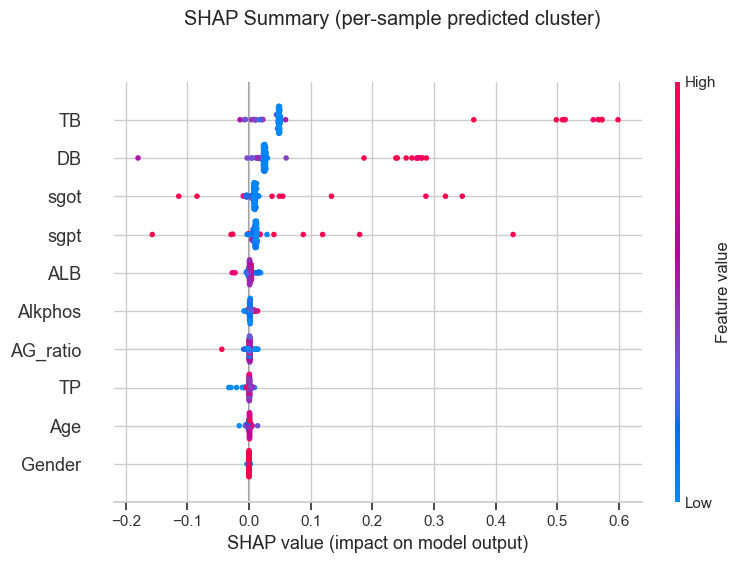

In [73]:
# SHAP summary (beeswarm) plot — per-sample predicted cluster
# This creates a single summary plot by selecting, for each sample,
# the SHAP values corresponding to its predicted class.
try:
    import numpy as np
    import shap
    import matplotlib.pyplot as plt

    # Sanity checks
    assert 'rf' in globals(), "RandomForest model (rf) not found. Run the training cell first."
    assert 'X_te' in globals() and 'y_te' in globals(), "Train/test split not found. Run the RF cell first."
    assert 'shap_values' in globals(), "SHAP values not found. Run the SHAP computation cell first."
    assert 'X_tree' in globals(), "X_tree (feature frame) not found."

    # Predicted class for each test sample
    y_pred = rf.predict(X_te)

    # Build a 2D SHAP matrix matching (n_samples, n_features)
    if isinstance(shap_values, np.ndarray):
        # Expect shapes: (n_samples, n_features) or (n_samples, n_features, n_classes)
        if shap_values.ndim == 3:
            # Select per-sample SHAP for predicted class
            shap_selected = np.stack([shap_values[i, :, y_pred[i]] for i in range(len(y_pred))], axis=0)
        elif shap_values.ndim == 2:
            shap_selected = shap_values
        else:
            raise ValueError(f"Unsupported SHAP ndarray ndim={shap_values.ndim}")
    elif isinstance(shap_values, list) and len(shap_values) > 0:
        # List-of-arrays format: one array per class, each (n_samples, n_features)
        shap_selected = np.stack([shap_values[y_pred[i]][i] for i in range(len(y_pred))], axis=0)
    else:
        raise TypeError(f"Unsupported SHAP values type: {type(shap_values)}")

    # Feature names align with X_tree columns
    feature_names = list(X_tree.columns)

    print(f"SHAP summary: selected matrix shape = {shap_selected.shape}; features = {len(feature_names)}")

    # Beeswarm summary plot (per-sample predicted class)
    shap.summary_plot(shap_selected, features=X_te, feature_names=feature_names, plot_type='dot', show=False)
    plt.gcf().suptitle('SHAP Summary (per-sample predicted cluster)', y=1.02)
    plt.tight_layout()
    plt.show()

    # Optional: bar summary for global importance
    # shap.summary_plot(shap_selected, features=X_te, feature_names=feature_names, plot_type='bar', show=False)
    # plt.gcf().suptitle('SHAP Global Importance (mean |SHAP|)', y=1.02)
    # plt.tight_layout()
    # plt.show()

except Exception as e:
    print(f"Failed to create SHAP summary plot: {e}")
    import traceback; traceback.print_exc()

Sample index: 20, Predicted class: 0


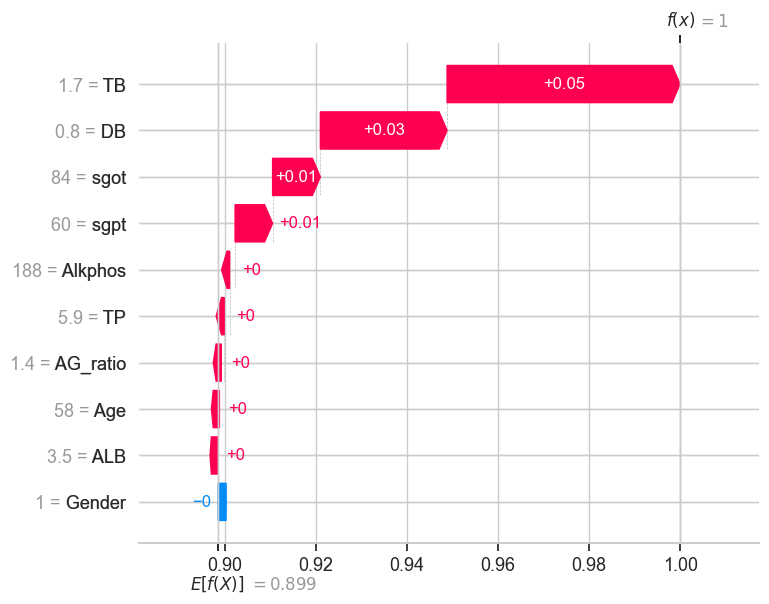

In [50]:
# SHAP waterfall plot for individual samples
import shap
import matplotlib.pyplot as plt
import numpy as np

# Choose a test sample index (e.g., 0, 1, 2...)
sample_idx = 20  # Change this to visualize other samples

# Get predicted class for the sample
pred_class = rf.predict(X_te)[sample_idx]

# Get SHAP values for the sample and its predicted class
if isinstance(shap_values, np.ndarray):
    if shap_values.ndim == 3:
        shap_sample = shap_values[sample_idx, :, pred_class]
        base_value = explainer.expected_value[pred_class] if hasattr(explainer, 'expected_value') else explainer.expected_value
    elif shap_values.ndim == 2:
        shap_sample = shap_values[sample_idx]
        base_value = explainer.expected_value if hasattr(explainer, 'expected_value') else explainer.expected_value
    else:
        raise ValueError("Unsupported SHAP ndarray shape.")
elif isinstance(shap_values, list) and len(shap_values) > 0:
    shap_sample = shap_values[pred_class][sample_idx]
    base_value = explainer.expected_value[pred_class] if hasattr(explainer, 'expected_value') else explainer.expected_value
else:
    raise TypeError("Unsupported SHAP values type.")

# Feature names and values
feature_names = list(X_tree.columns)
feature_values = X_te.iloc[sample_idx] if hasattr(X_te, 'iloc') else X_te[sample_idx]

print(f"Sample index: {sample_idx}, Predicted class: {pred_class}")

# Waterfall plot
shap.plots.waterfall(shap.Explanation(
    values=shap_sample,
    base_values=base_value,
    data=feature_values,
    feature_names=feature_names
))
plt.show()

# Tip: Change sample_idx above to visualize other test samples.